# Packages and functions

In [1]:
import os
import umap
import time
import random
import anndata
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import editdistance
import colorsys as cs
import seaborn as sns
import memory_profiler
import scipy.sparse as sp 
from collections import Counter
import matplotlib.pyplot as plt
from scipy.spatial import procrustes
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from matplotlib.cm import ScalarMappable
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import orthogonal_procrustes
from matplotlib.colors import LinearSegmentedColormap, Normalize


def make_colormap(seq):
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return LinearSegmentedColormap('CustomMap', cdict)
    

def build_6mer_dist(bc_list):
    start_km = {}
    mid_km = {}
    end_km = {}
    for bc in bc_list:
        start_km.setdefault(bc[:6] , []).append(bc)
        mid_km.setdefault(bc[4:10], []).append(bc)
        end_km.setdefault(bc[-6:] , []).append(bc)
    return start_km,mid_km,end_km


def barcode_matching(bc_pos_dict,spatial_bc_list,max_dist=1):
    bc_matching_dict = {}
    def get_sel_bc(bc):
        res = []
        if bc[:6] in start_km:
            res += start_km[bc[:6]]
        if bc[-6:] in end_km:
            res += end_km[bc[-6:]]
        if bc[4:10] in mid_km:
            res += mid_km[bc[4:10]]
        return set(res)
    exact_match = 0
    fuzzy_match = 0
    bc_ref_list = list(bc_pos_dict.keys())
    start_km,mid_km,end_km = build_6mer_dist(bc_ref_list)
    for bc in spatial_bc_list:
        bc_old = bc
        #bc = "".join([bc[it] for it in [1,2,3,4,5,6,7,9,10,11,12,13] ])
        if bc in bc_pos_dict:
            exact_match += 1
            bc_matching_dict[bc_old] = bc
        else:
            sel_bc = get_sel_bc(bc)
            #sel_bc = bc_ref_list
            if len(sel_bc)>0:
                fz = [(it, editdistance.eval(it, bc)) for it in sel_bc]
                fz = [it for it in fz if it[1]<=max_dist]
                fz.sort(key=lambda x:x[1])
                if len(fz)==0:
                    continue
                ## if there are two barcodes with the same edit distance, choose the one with higher error rate in the last base
                if len(fz)>1 and fz[0][1]==fz[1][1]:
                    if editdistance.eval(fz[0][0][:-1], bc[-1])>editdistance.eval(fz[1][0][:-1], bc[-1]):  # higher error rate in the last base of the barcode
                        fuzzy_match += 1
                        bc_matching_dict[bc_old] = fz[1][0]
                    elif editdistance.eval(fz[0][0][:-1], bc[-1])<editdistance.eval(fz[1][0][:-1], bc[-1]):
                        fuzzy_match += 1
                        bc_matching_dict[bc_old] = fz[0][0]
                else:
                    fuzzy_match += 1
                    bc_matching_dict[bc_old] = fz[0][0]
    return bc_matching_dict,exact_match,fuzzy_match

def blind_cnt_distribution(bead_all, bead_type):
    plt.figure(figsize=(8,6))
    sns.histplot(np.log10(bead_all['total_cnt']), bins=50)
    plt.xlabel('log10(total count)', fontsize=12)
    plt.ylabel('number of '+bead_type, fontsize=12)
    plt.title('blind '+bead_type+' total count distribution ({}), median={}'.format(len(bead_all), bead_all['total_cnt'].median()), fontsize=16, pad=20)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.savefig(os.path.join(out_dir,bead_type+'_blind_cnt_distribution.png'),dpi=300)
    plt.close()

def blind_cover_bc_distribution(bead_cover_bc, bead_type):
    plt.figure(figsize=(8,6))
    sns.histplot(bead_cover_bc['cnt'], bins=50)
    plt.xlabel('bead covered', fontsize=12)
    plt.ylabel('number of '+bead_type, fontsize=12)
    plt.title(bead_type+' bead covered distribution ({}), median={}'.format(len(bead_cover_bc), bead_cover_bc['cnt'].median()), fontsize=16, pad=20)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.savefig(os.path.join(out_dir,bead_type+'_blind_cover_bc_distribution.png'),dpi=300)
    plt.close()

# generate spase matrix from matching, with selection on anchor or target
def get_matrix(match_df,min_a_cnt,max_a_cnt, min_t_cnt,max_t_cnt, anchor, target):
    a_all = match_df.groupby(anchor)['cnt'].sum().reset_index(name='total_cnt')  
    a_sel = a_all.loc[(a_all['total_cnt']>min_a_cnt) & (a_all['total_cnt']<max_a_cnt),]
    t_all = match_df.groupby(target)['cnt'].sum().reset_index(name='total_cnt')  
    t_sel = t_all.loc[(t_all['total_cnt']>min_t_cnt) & (t_all['total_cnt']<max_t_cnt),]
    match_df = match_df[(match_df[anchor].isin(a_sel[anchor])) & (match_df[target].isin(t_sel[target]))]
    a_list = match_df.groupby(anchor)['cnt'].sum().reset_index(name='total_cnt') 
    t_list = match_df.groupby(target)['cnt'].sum().reset_index(name='total_cnt') 
    print('a: {}'.format(len(a_list)))
    print('t: {}'.format(len(t_list)))
    a_dict = dict()
    t_dict = dict()
    for i in range(len(a_list)):
        a_dict[a_list.iloc[i,0]] = i
    for j in range(len(t_list)):
        t_dict[t_list.iloc[j,0]] = j
    a_coo = []
    t_coo = []
    [a_coo.append(a_dict[a]) for a in match_df[anchor]]
    [t_coo.append(t_dict[t]) for t in match_df[target]]
    counts_coo = sp.coo_matrix((match_df['cnt'], (a_coo, t_coo)))
    # counts = counts_coo.tocsr().toarray()
    counts = counts_coo.tocsr()
    return counts, a_list, t_list

def get_col(coords):
    plot_df = coords.copy()
    b_list = [1] * len(plot_df)
    r_list = (plot_df.xcoord.values - plot_df.xcoord.min()) / (
                plot_df.xcoord.max() - plot_df.xcoord.min())
    g_list = (plot_df.ycoord.values - plot_df.ycoord.min()) / (
                plot_df.ycoord.max() - plot_df.ycoord.min())
    # my_h = plot_df['xcoord']
    # my_h = (my_h - np.min(my_h))
    # my_h = 0.2+my_h * (0.8 / np.max(my_h))
    # my_s = np.ones(len(my_h)) * 0.5
    # my_l = plot_df['ycoord']
    # my_l = (my_l - np.min(my_l))
    # my_l = 0.2 + my_l * (0.7 / np.max(my_l))
    # hls_color = np.column_stack((my_h, my_l, my_s))
    # rgb_color = [cs.hls_to_rgb(p[0], p[1], p[2]) for p in hls_color]
    rgb_color = [(r_list[i], g_list[i], b_list[i]) for i in range(len(plot_df))]
    return rgb_color


def get_truth(wlist,pos_df):
    w_truth = pos_df[pos_df['barcode'].isin(wlist)]
    w_truth = w_truth.sort_values(by=['barcode'])
    w_col = get_col(w_truth)
    return w_truth, w_col


def get_pa(pos_truth,pos_recon):
    mtx1, mtx2, disparity = procrustes(pos_truth[['xcoord','ycoord']], pos_recon[['xcoord','ycoord']])
    
    pos_truth_translate = pos_truth.copy()
    pos_truth_translate['xcoord'] = pos_truth_translate['xcoord'] - np.mean(pos_truth_translate['xcoord'])
    pos_truth_translate['ycoord'] = pos_truth_translate['ycoord'] - np.mean(pos_truth_translate['ycoord'])
    
    scaling = np.sqrt(np.trace(np.dot(pos_truth_translate[['xcoord','ycoord']], pos_truth_translate[['xcoord','ycoord']].T)))
    scaling_2 = np.sqrt(np.trace(np.dot(pos_truth_translate[['xcoord','ycoord']], pos_truth_translate[['xcoord','ycoord']].T)))/np.sqrt(np.trace(np.dot(mtx2, mtx2.T)))

    mtx1_scaled = mtx1*scaling*0.72
    mtx2_scaled = mtx2*scaling_2*0.72
    
    dist = pos_truth_translate.copy()
    dist['x'] = mtx1_scaled[:,0] - mtx2_scaled[:,0]
    dist['y'] = mtx1_scaled[:,1] - mtx2_scaled[:,1]
    dist['r'] = np.sqrt(dist['x']**2 + dist['y']**2)
    
    return disparity, mtx1_scaled, mtx2_scaled, dist

def rigid_transfrom(pos, a_recon):
    bc_pos_dict = Counter(pos['barcode'])
    a_bc_matching_dict,_,_ = barcode_matching(bc_pos_dict, a_recon[anchor].values, max_dist=1) 
    a_truth, a_col = get_truth(list(a_bc_matching_dict.values()), pos)
    
    a_umap_matched = a_recon[a_recon[anchor].isin(a_bc_matching_dict.keys())]
    a_umap_matched = a_umap_matched.copy()
    a_umap_matched.loc[:,'barcode'] = a_umap_matched[anchor].map(a_bc_matching_dict)
    a_umap_matched = a_umap_matched[['xcoord','ycoord','barcode']]
    a_umap_matched = a_umap_matched.groupby('barcode').mean().reset_index()
    a_umap_matched = a_umap_matched.sort_values(by=['barcode'])
    
    mtx1, mtx2, disparity = procrustes(a_truth[['xcoord','ycoord']], a_umap_matched[['xcoord','ycoord']])

    a_matched_translate = a_umap_matched.copy()
    a_matched_translate['xcoord'] = a_matched_translate['xcoord'] - np.mean(a_matched_translate['xcoord'])
    a_matched_translate['ycoord'] = a_matched_translate['ycoord'] - np.mean(a_matched_translate['ycoord'])

    R, s = orthogonal_procrustes(a_matched_translate[['xcoord','ycoord']], mtx2)
    a_transformed = s * np.dot(a_recon[['xcoord','ycoord']], R)

    a_scale = a_recon.copy()
    a_scale['xcoord'] = a_transformed[:,0]/(np.max(a_transformed[:,0])-np.min(a_transformed[:,0]))*(np.max(pos.xcoord)-np.min(pos.xcoord))*0.72
    a_scale['ycoord'] = a_transformed[:,1]/(np.max(a_transformed[:,1])-np.min(a_transformed[:,1]))*(np.max(pos.ycoord)-np.min(pos.ycoord))*0.72

    a_scale['xcoord'] = a_scale['xcoord'] - np.mean(a_scale['xcoord'])
    a_scale['ycoord'] = a_scale['ycoord'] - np.mean(a_scale['ycoord'])

    return a_scale

# Load data

In [4]:
sample = 'c58_8'
anchor = 'V10'
target = 'V9A30'
sample_folder = os.path.join('/mnt/thechenlab/Chenlei/Slide_recon/Data_Figures/Slide_recon_seq',sample)

In [4]:
blind_raw = pd.read_csv(os.path.join(sample_folder, sample+'_blind_raw_reads_filtered.csv.gz'))
blind_sum = blind_raw.groupby(['R1_bc', 'R2_bc']).size().reset_index(name='cnt')
blind_sum.columns = [anchor,target,'cnt']

# statistics of umi per bead
a_all = blind_sum.groupby(anchor)['cnt'].sum().reset_index(name='total_cnt')
t_all = blind_sum.groupby(target)['cnt'].sum().reset_index(name='total_cnt')

# statistics of covered bead per bead
a_cover_bc = blind_sum.groupby(anchor).count()
t_cover_bc = blind_sum.groupby(target).count()

In [10]:
%reload_ext memory_profiler

# Diffusion in ground truth

In [43]:
pos = pd.read_csv(os.path.join(sample_folder,sample+'_matched_bead_location.csv.gz'))

In [42]:
pos = pd.read_csv(os.path.join(sample_folder,sample+'_matched_bead_location.csv.gz'))
match_raw = pd.read_csv(os.path.join(sample_folder,sample+'_raw_matched_reads.csv.gz'))
match_sum = match_raw.groupby(['P5_bc', 'V9_bc']).size().reset_index(name='cnt')
match_sum.columns = [anchor, target, 'cnt']

a_all = match_sum.groupby(anchor)['cnt'].sum().reset_index(name='total_cnt') 
t_all = match_sum.groupby(target)['cnt'].sum().reset_index(name='total_cnt')

In [33]:
pos['xcoord'] = pos['xcoord']-np.mean(pos['xcoord'])
pos['ycoord'] = pos['ycoord']-np.mean(pos['ycoord'])
pos['xcoord'] = pos['xcoord']*0.72
pos['ycoord'] = pos['ycoord']*0.72

In [6]:
bead_all = a_all
bead_type = anchor
base_type = target

match_pos = pd.merge(match_sum, pos, left_on=base_type, right_on='barcode')
bead_all = bead_all.sort_values(by='total_cnt', ascending=False)

## Fig1_d_left

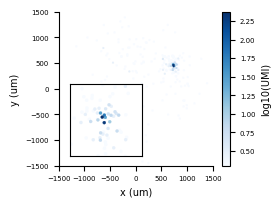

In [77]:
b_n = 15000
b = bead_all.iloc[b_n, 0]
b_match = match_pos.loc[match_pos[bead_type] == b,]
b_match = b_match.sort_values(by='cnt', ascending=True)

fig, ax = plt.subplots(figsize=(2.5, 2)) 
scatter = sns.scatterplot(x=b_match['xcoord'], y=b_match['ycoord'], hue=np.log10(b_match['cnt']+1)
                          ,palette='Blues', s=2,legend=None,edgecolor=None)
ax.set_xlim(-1500,1500)
ax.set_ylim(-1500,1500)
ax.set_xlabel('x (um)', fontsize=7)
ax.set_ylabel('y (um)', fontsize=7)
ax.tick_params(axis='both', which='major', labelsize=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
norm = plt.Normalize(vmin=np.log10(b_match['cnt']+1).min(), vmax=np.log10(b_match['cnt']+1).max())
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax,pad=0.05)
cbar.set_label('log10')
cbar.ax.tick_params(labelsize=5, which='major') 
cbar.set_label('log10(UMI)', fontsize=7)
ax.set_aspect('equal')

ax2 = plt.axes([0.14, 0.16, .36, .36])
sns.scatterplot(x=b_match['xcoord'], y=b_match['ycoord'], hue=np.log10(b_match['cnt']+1)
                          ,palette='Blues', s=5,legend=None,edgecolor=None, ax=ax2)
ax2.set_xlim(600,900)
ax2.set_ylim(300,600)
ax2.set_aspect('equal')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xticks([])
ax2.set_yticks([])

# plt.savefig(os.path.join(out_dir,'Fig2b_a_diffusion_groundtruth.svg'),dpi=300)
plt.show()

## Fig1_d_right

In [62]:
x_values = np.linspace(-1500, 1500, 1000)
densities_all = []
bead_all = bead_all.sort_values(by='total_cnt', ascending=False)
bi = range(0, 3000)
for b_n in bi:
    if b_n % 200 == 0:
        print(b_n)
    b = bead_all.iloc[b_n, 0]
    b_match = match_pos.loc[match_pos[bead_type] == b,]
    if len(b_match) > 4:
        b_x = np.repeat(b_match['xcoord'],b_match['cnt'])
        b_x -= np.mean(b_x)
        kde = gaussian_kde(b_x)
        densities = kde.evaluate(x_values)
        densities_all.append(np.array(densities))

densities_average = np.mean(np.array(densities_all), axis=0)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800


In [28]:
x = x_values
y = densities_average
peak_value = np.max(y)

# Step 2: Find half maximum
half_max = peak_value / 2

# Step 3: Locate points on the distribution
# np.abs(y - half_max) finds the absolute difference between y values and half max
# np.argmin finds the index of the smallest value in this difference array, 
# which will be closest to the half maximum
left_idx = np.argmin(np.abs(y[:len(y)//2] - half_max))
right_idx = np.argmin(np.abs(y[len(y)//2:] - half_max)) + len(y)//2

# Step 4: Calculate FWHM
fwhm = x[right_idx] - x[left_idx]

print("FWHM:", fwhm)

FWHM: 123.12312312312315


/home/thechenlab/miniconda3/envs/slidelock/lib/python3.11/site-packages/seaborn/relational.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)


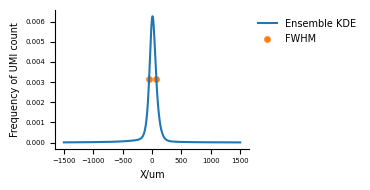

In [55]:
plt.figure(figsize=(3.8, 2))

sns.lineplot(x=x_values, y=densities_average, label='Ensemble KDE')
sns.scatterplot(x=[x[left_idx],x[right_idx]], y=[y[left_idx],y[right_idx]], s=20,
                label='FWHM',c = sns.color_palette("tab10")[1],edgecolor=None)

# plt.xlim(-100,100)
plt.xlabel('X/um', fontsize=7)
plt.ylabel('Frequency of UMI count', fontsize=7)
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
# plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='both',labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join(out_dir,'Fig2c_a_x_average_kde.svg'),dpi=300)
plt.show()

# generate diffusion matrix

In [12]:
%%memit

time0 = time.time()
a_min = 0
a_max = 100000
t_min = 0
t_max = 100000

counts, a_sel, t_sel = get_matrix(blind_sum, min_a_cnt=a_min, max_a_cnt=a_max, min_t_cnt=t_min, max_t_cnt=t_max, anchor=anchor, target=target)
time2 = time.time()
print('time for generating matrix: ', time2-time0)

a: 19408
t: 19681
time for generating matrix:  8.757817029953003
peak memory: 6351.37 MiB, increment: 1.95 MiB


In [13]:
counts

<19408x19681 sparse matrix of type '<class 'numpy.int64'>'
	with 9070895 stored elements in Compressed Sparse Row format>

# Reconstruction with UMAP

In [14]:
%%memit
n_epo = 50000

time5 = time.time()
reducer = umap.UMAP(metric='cosine',
                    n_neighbors=25, 
                    min_dist=0.99, 
                    low_memory=False, 
                    n_components=2, 
                    # random_state=0, 
                    verbose=True, 
                    n_epochs=n_epo,
                    # output_dens = True,
                    # local_connectivity = 30,
                    learning_rate = 1)
embedding = reducer.fit_transform(np.log1p(counts))
time_loop = time.time()
print('umap: ', time_loop-time5)

UMAP(angular_rp_forest=True, learning_rate=1, low_memory=False, metric='cosine', min_dist=0.99, n_epochs=50000, n_neighbors=25, verbose=True)
Sat Mar 30 12:06:17 2024 Construct fuzzy simplicial set
Sat Mar 30 12:06:17 2024 Finding Nearest Neighbors
Sat Mar 30 12:06:17 2024 Building RP forest with 12 trees
Sat Mar 30 12:06:20 2024 metric NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sat Mar 30 12:07:37 2024 Finished Nearest Neighbor Search
Sat Mar 30 12:07:39 2024 Construct embedding


Epochs completed:   0%|            0/50000 [00:00]

	completed  0  /  50000 epochs
	completed  5000  /  50000 epochs
	completed  10000  /  50000 epochs
	completed  15000  /  50000 epochs
	completed  20000  /  50000 epochs
	completed  25000  /  50000 epochs
	completed  30000  /  50000 epochs
	completed  35000  /  50000 epochs
	completed  40000  /  50000 epochs
	completed  45000  /  50000 epochs
Sat Mar 30 12:32:50 2024 Finished embedding
umap:  1593.8311195373535
peak memory: 6655.95 MiB, increment: 304.25 MiB


In [29]:
a_recon = pd.DataFrame(embedding)
a_recon.columns = ['xcoord','ycoord']
a_recon.insert(loc=0, column=anchor, value=a_sel[anchor])

In [50]:
a_recon_transform = rigid_transfrom(pos, a_recon)
embedding = a_recon_transform[['xcoord','ycoord']].values

# Evaluation with absolute error

In [ ]:
# need to reload groundtruth
pos = pd.read_csv(os.path.join(sample_folder, sample+'_matched_bead_location.csv.gz'))

bc_pos_dict = Counter(pos['barcode'])
a_bc_matching_dict,_,_ = barcode_matching(bc_pos_dict, a_sel[anchor].values, max_dist=1) 

a_truth, a_col = get_truth(list(a_bc_matching_dict.values()), pos)

In [62]:
recon_umap = pd.DataFrame(embedding)
a_umap  = recon_umap.copy()
a_umap[anchor] = a_sel[anchor].values
a_umap.columns = ['xcoord', 'ycoord', anchor]
a_umap_matched = a_umap[a_umap[anchor].isin(a_bc_matching_dict.keys())]
a_umap_matched = a_umap_matched.copy()
a_umap_matched.loc[:,'barcode'] = a_umap_matched[anchor].map(a_bc_matching_dict)
a_umap_matched = a_umap_matched[['xcoord','ycoord','barcode']]
a_umap_matched = a_umap_matched.groupby('barcode').mean().reset_index()
a_umap_matched = a_umap_matched.sort_values(by=['barcode'])

## Fig1_e

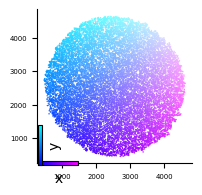

In [63]:
# need to scale by 0.72 from pixel to µm
plt.figure(figsize=(2, 2))
sns.scatterplot(x=a_truth['xcoord'], y=a_truth['ycoord'], c=a_col, s=0.8, edgecolor=None)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.xlabel('')
plt.ylabel('')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

x_cmap = make_colormap([(0, 0, 1), (1, 0, 1)])  # Blue to Magenta for x
y_cmap = make_colormap([(0, 0, 1), (0, 1, 1)])  # Blue to Cyan for y

fig = plt.gcf()
sm_x = ScalarMappable(cmap=x_cmap, norm=Normalize(0,1))
sm_x.set_array([])
cb_ax_x = fig.add_axes([0.13, 0.1, 0.2, 0.02])  # Adjust these values to position your colorbar
cbar_x = plt.colorbar(sm_x, cax=cb_ax_x, orientation='horizontal', ticks=[])
cbar_x.set_label('x')

sm_y = ScalarMappable(cmap=y_cmap, norm=Normalize(0,1))
sm_y.set_array([])
cb_ax_y = fig.add_axes([0.13, 0.1, 0.02, 0.2])  # Adjust these values to position your colorbar
cbar_y = plt.colorbar(sm_y, cax=cb_ax_y, orientation='vertical', ticks=[])
cbar_y.set_label('y')

# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig2','Fig2q_c58_8_truth.svg'),dpi=300)
# plt.close()
plt.show()

## Fig1_f

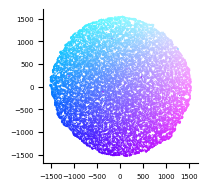

In [64]:
plt.figure(figsize=(2, 2))
sns.scatterplot(x=a_umap_matched['xcoord'], y=a_umap_matched['ycoord'], c=a_col, s=0.8, edgecolor=None)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.xlabel('')
plt.ylabel('')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig2','Fig2r_c58_8_recon.svg'),dpi=300)
# plt.close()
plt.show()

## FigS3_a

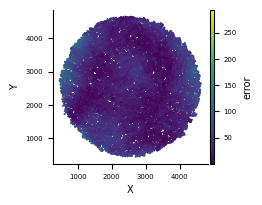

In [70]:
close_index = [index for index, element in enumerate(a_comp['r'].values) if element < 300]

fig = plt.figure(figsize=(2, 2))
ax = plt.axes()
im = ax.scatter(x=a_truth['xcoord'].values[close_index], y=a_truth['ycoord'].values[close_index], c=a_comp['r'].values[close_index], alpha=1, s=2.5, edgecolor='none')

# plt.title('Simulated Anchor Location ({})'.format(n_a), fontsize=16, pad=20)
# plt.annotate('simulated anchor location ({})'.format(n_a), xy=(0.5, -0), xycoords='axes fraction', ha='center', va='center', fontsize=16)
plt.xlabel('X', fontsize=7)
plt.ylabel('Y', fontsize=7)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax, pad=0.05)
cbar.ax.tick_params(labelsize=5, which='major') 
cbar.set_label('error', fontsize=7)
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS3','FigS3e_c58_8_a_error_spatial.svg'),dpi=300)
# plt.close()
plt.show()

## FigS3_b

In [60]:
da, a_truth_pa, a_recon_pa, a_comp = get_pa(a_truth,a_umap_matched)

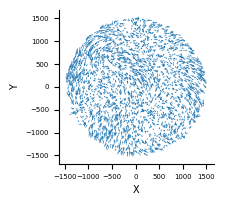

In [61]:
idx_a = [random.randint(1, len(a_truth_pa)-1) for _ in range(3000)]
fig, ax = plt.subplots(figsize=(2, 2))

# Plotting the starting and ending points
for (x1, y1), (x2, y2) in zip(a_truth_pa[idx_a,:], a_recon_pa[idx_a,:]):
    # ax.scatter(x1, y1, color='blue', marker='o', s=15, label='truth')  # starting point
    # ax.scatter(x2, y2, color='red', marker='x', s=15, label='recon')   # ending point
    if abs(x2-x1)<200 and abs(y2-y1)<200:
        ax.arrow(x1, y1, x2 - x1, y2 - y1, width=10, head_width=30, head_length=30, edgecolor='none', shape = 'full')

# Setting labels and title
plt.xlabel('X', fontsize=7)
plt.ylabel('Y', fontsize=7)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS3','FigS3c_c58_8_displacement_vectors.svg'),dpi=300)

plt.show()

## FigS3_c

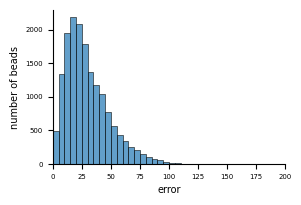

In [65]:
plt.figure(figsize=(3, 2))
sns.histplot(a_comp['r'], bins=np.arange(0,200,5), alpha=0.7, edgecolor='black')
plt.xlabel('error', fontsize=7)
plt.ylabel('number of beads', fontsize=7)
# plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0,200)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS2','FigS2d_c58_8_error_distribution.svg'),dpi=300)
plt.show()

# Error at measurement length

In [72]:
a_comp.reset_index(drop=True, inplace=True)
indices = a_comp[a_comp['r'] < 200].index.tolist()

a_truth_pa_pairwise = cdist(a_truth_pa[indices,:], a_truth_pa[indices,:])
a_recon_pa_pairwise = cdist(a_recon_pa[indices,:], a_recon_pa[indices,:])
diff = a_recon_pa_pairwise - a_truth_pa_pairwise

intervals = [(i*30+0.001, (i+1)*30) for i in range(100)]

rms_values = []
rms_sd = []
a_truth_pairwise = a_truth_pa_pairwise.flatten()
diff = diff.flatten()

for interval in intervals:
    mask = (a_truth_pairwise >= interval[0]) & (a_truth_pairwise < interval[1])
    corresponding_values = diff[mask]
    rms = np.sqrt(np.mean(corresponding_values**2))
    sd = np.std(np.sqrt(corresponding_values**2))
    rms_values.append(rms)
    rms_sd.append(sd)

## Fig1_i

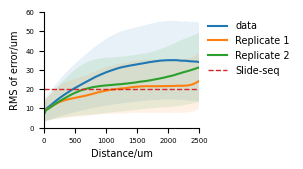

In [79]:
plt.figure(figsize=(2, 1.5))
plt.plot([i*30 for i in range(100)],rms_values_c58_8, label='data')

plt.fill_between([i*30 for i in range(100)], [rms_values_c58_8[i] - rms_sd_c58_8[i] for i in range(100)], 
                 [rms_values_c58_8[i] + rms_sd_c58_8[i] for i in range(100)], alpha=0.1)
plt.plot([i*30 for i in range(100)],rms_values_c58_4, label='Replicate 1')

plt.fill_between([i*30 for i in range(100)], [rms_values_c58_4[i] - rms_sd_c58_4[i] for i in range(100)], 
                 [rms_values_c58_4[i] + rms_sd_c58_4[i] for i in range(100)], alpha=0.1)
plt.plot([i*30 for i in range(100)],rms_values_c58_5, label='Replicate 2')

plt.fill_between([i*30 for i in range(100)], [rms_values_c58_5[i] - rms_sd_c58_5[i] for i in range(100)], 
                 [rms_values_c58_5[i] + rms_sd_c58_5[i] for i in range(100)], alpha=0.1)
plt.plot([i*30 for i in range(100)],[20]*100, linestyle='dashed', label='Slide-seq', linewidth=1)
plt.xlim(0,2500)
plt.ylim(0,60)
# plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
plt.xlabel('Distance/um', fontsize=7)
plt.ylabel('RMS of error/um', fontsize=7)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig2'
#                          ,'Fig2o_RMS_error_compare.svg'),dpi=300)
# plt.close()
plt.show()

## FigS3_d

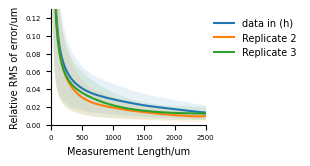

In [78]:
plt.figure(figsize=(2, 1.5))
plt.plot([i*30 for i in range(1,100)],[rms_values_c58_8[i]/(i*30) for i in range(1,100)], label='data in (h)')
# plt.plot([i*30 for i in range(100)],[20]*100, linestyle='dashed', label='Slide-seq')
plt.fill_between([i*30 for i in range(1,100)], [(rms_values_c58_8[i] - rms_sd_c58_8[i])/(i*30) for i in range(1,100)], 
                 [(rms_values_c58_8[i] + rms_sd_c58_8[i])/(i*30) for i in range(1,100)], alpha=0.1)
plt.plot([i*30 for i in range(1,100)],[rms_values_c58_4[i]/(i*30) for i in range(1,100)], label='Replicate 2')
# plt.plot([i*30 for i in range(100)],[20]*100, linestyle='dashed', label='Slide-seq')
plt.fill_between([i*30 for i in range(1,100)], [(rms_values_c58_4[i] - rms_sd_c58_4[i])/(i*30) for i in range(1,100)], 
                 [(rms_values_c58_4[i] + rms_sd_c58_4[i])/(i*30) for i in range(1,100)], alpha=0.1)
plt.plot([i*30 for i in range(1,100)],[rms_values_c58_5[i]/(i*30) for i in range(1,100)], label='Replicate 3')
# plt.plot([i*30 for i in range(100)],[20]*100, linestyle='dashed', label='Slide-seq')
plt.fill_between([i*30 for i in range(1,100)], [(rms_values_c58_5[i] - rms_sd_c58_5[i])/(i*30) for i in range(1,100)], 
                 [(rms_values_c58_5[i] + rms_sd_c58_5[i])/(i*30) for i in range(1,100)], alpha=0.1)
# plt.plot([i*30 for i in range(100)],[20]*100, linestyle='dashed', label='Slide-seq', linewidth=1)
plt.xlim(0,2500)
plt.ylim(0,0.13)
# plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
plt.xlabel('Measurement Length/um', fontsize=7)
plt.ylabel('Relative RMS of error/um', fontsize=7)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS2'
#                          ,'FigS2q_relative_RMS_error_compare.svg'),dpi=300)
# # plt.close()
plt.show()

# Slide-seq data with reconstruction results

mRNA library has been through Slide-seq pipeline and RCTD for cell type decomposition

In [2]:
adata_recon = sc.read_h5ad('/mnt/thechenlab/Chenlei/spotmapping/fiducial/data_for_paper/slide_map_seq/c58_8_recon_RCTD.h5ad')

## Fig1_g

In [85]:
bead_umap = pd.DataFrame(adata_recon.obsm['X_umap'], index=adata_recon.obs.index, columns=['UMAP1','UMAP2'])
bead_umap = bead_umap.merge(adata_recon.obs[['spot_class','first_type']], left_index=True, right_index=True)

In [87]:
type12 = ['CA3','Denate','Cajal_Retzius','Interneuron','CA1','Oligodendrocyte','Entorihinal','Microglia_Macrophages'
          ,'Astrocyte','Choroid','Neuron.Slc17a6','Ependymal']

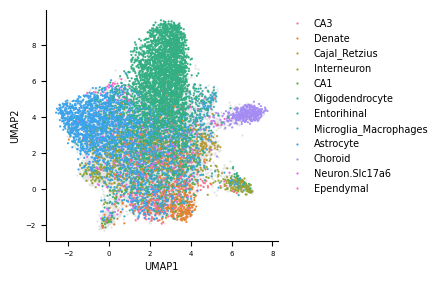

In [88]:
data1 = bead_umap[(bead_umap['spot_class']=='singlet') & (bead_umap['first_type'].isin(type12))]
data2 = bead_umap[(bead_umap['spot_class']!='singlet') | (-bead_umap['first_type'].isin(type12))]

plt.figure(figsize=(3, 3))

sns.scatterplot(data2, x="UMAP1", y="UMAP2", color='#E3E3E3', s=2, edgecolor=None)
sns.scatterplot(data1, x="UMAP1", y="UMAP2", hue="first_type", s=2, hue_order=type12,
                edgecolor=None, palette=sns.color_palette("husl", 12))

plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
plt.xlabel('UMAP1', fontsize=7)
plt.ylabel('UMAP2', fontsize=7)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(os.path.join(out_dir,'Fig2m_umap_RCTD_12_type.svg'),dpi=300)
# plt.close()
plt.show()

## Fig1_h

In [105]:
cell_type_bead = adata_recon.obs

bead_loc = pd.DataFrame(adata_recon.obsm['spatial'], index=adata_recon.obs.index, columns=['xcoord','ycoord'])
bead_loc.ycoord = - bead_loc.ycoord

cell_type_bead = cell_type_bead.merge(bead_loc, left_index=True, right_index=True)

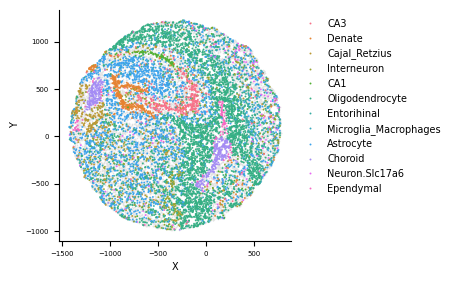

In [106]:
## Fig2k
data1 = cell_type_bead[(cell_type_bead['spot_class']=='singlet') & (cell_type_bead['first_type'].isin(type12))]
data2 = cell_type_bead[(cell_type_bead['spot_class']!='singlet') | (-cell_type_bead['first_type'].isin(type12))]

plt.figure(figsize=(3, 3))

sns.scatterplot(data2, x="xcoord", y="ycoord", color='#E3E3E3', s=1, edgecolor=None)
sns.scatterplot(data1, x="xcoord", y="ycoord", hue="first_type", hue_order=type12,
                s=1.5, edgecolor=None, palette=sns.color_palette("husl", 12))

# plt.title('Simulated Anchor Location ({})'.format(n_a), fontsize=16, pad=20)
# plt.annotate('simulated anchor location ({})'.format(n_a), xy=(0.5, -0), xycoords='axes fraction', ha='center', va='center', fontsize=16)
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
plt.xlabel('X', fontsize=7)
plt.ylabel('Y', fontsize=7)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(os.path.join(out_dir,'Fig2k_RCTD_12_type.svg'),dpi=300)
# plt.close()
plt.show()

## FigS3_g

In [117]:
cell_type_bead_truth = adata_recon.obs
a_truth.ycoord = -a_truth.ycoord
cell_type_bead_truth = cell_type_bead_truth.merge(a_truth.set_index('barcode'), left_index=True, right_index=True)

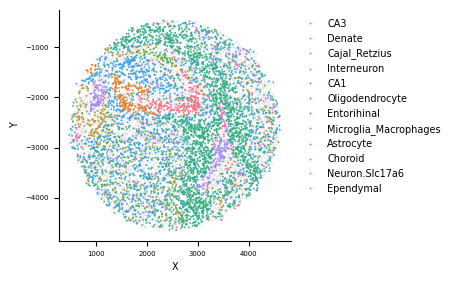

In [119]:
data1 = cell_type_bead_truth[(cell_type_bead_truth['spot_class']=='singlet') & (cell_type_bead_truth['first_type'].isin(type12))]
data2 = cell_type_bead_truth[(cell_type_bead_truth['spot_class']!='singlet') | (-cell_type_bead_truth['first_type'].isin(type12))]

plt.figure(figsize=(3, 3))

sns.scatterplot(data2, x="xcoord", y="ycoord", color='#E3E3E3', s=1, edgecolor=None)
sns.scatterplot(data1, x="xcoord", y="ycoord", hue="first_type", hue_order=type12,
                s=1.5, edgecolor=None, palette=sns.color_palette("husl", 12))

# plt.title('Simulated Anchor Location ({})'.format(n_a), fontsize=16, pad=20)
# plt.annotate('simulated anchor location ({})'.format(n_a), xy=(0.5, -0), xycoords='axes fraction', ha='center', va='center', fontsize=16)
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
plt.xlabel('X', fontsize=7)
plt.ylabel('Y', fontsize=7)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS2','FigS2l_RCTD_12_type_truth.svg'),dpi=300)
# plt.close()
plt.show()

# CA1 width

In [10]:
adata_truth = sc.read_h5ad('/mnt/thechenlab/Chenlei/spotmapping/fiducial/data_for_paper/slide_map_seq/c58_8_truth_scanpy.h5ad')

## FigS1_j

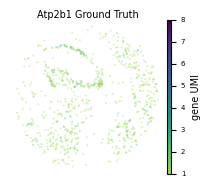

In [53]:
gene_index = adata_truth.var_names.get_loc('Atp2b1')
gene_expression_data = adata_truth.X[:, gene_index]
non_zero_indices = [index for index, element in enumerate(gene_expression_data) if element != 0]

fig = plt.figure(figsize=(2, 2))
ax = plt.axes()
im = ax.scatter(adata_truth.obsm['spatial'][non_zero_indices,0], -adata_truth.obsm['spatial'][non_zero_indices,1], c=gene_expression_data[non_zero_indices],cmap=viridis_half, alpha=1, s=0.03)
plt.tick_params(axis='both', which='major', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.title('Atp2b1 Ground Truth', fontsize=7, pad=0.05)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax, pad=0.05)
cbar.ax.tick_params(labelsize=5, which='major') 
cbar.set_label('gene UMI', fontsize=7)
# plt.savefig(os.path.join(out_dir,'Fig2h_1_Atp2b1_truth.svg'),dpi=300)
# plt.close()
plt.show()

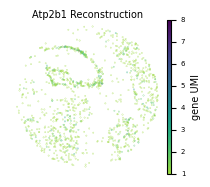

In [52]:
## Fig2h_2

gene_index = adata_recon.var_names.get_loc('Atp2b1')
gene_expression_data = adata_recon.X[:, gene_index]
non_zero_indices = [index for index, element in enumerate(gene_expression_data) if element != 0]

fig = plt.figure(figsize=(2, 2))
ax = plt.axes()
im = ax.scatter(adata_recon.obsm['spatial'][non_zero_indices,0], -adata_recon.obsm['spatial'][non_zero_indices,1], c=gene_expression_data[non_zero_indices],cmap=viridis_half, alpha=1, s=0.03)
plt.tick_params(axis='both', which='major', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.title('Atp2b1 Reconstruction', fontsize=7, pad=0.05)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax, pad=0.05)
cbar.ax.tick_params(labelsize=5, which='major') 
cbar.set_label('gene UMI', fontsize=7)
plt.savefig(os.path.join(out_dir,'Fig2h_2_Atp2b1_recon.svg'),dpi=300)
# plt.close()
plt.show()

In [13]:
CA1_values = pd.read_csv(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/data_for_paper/slide_map_seq','CA1_width_fiji.csv'))
CA1_values['distance_um'] = (CA1_values.distance_pixel-100) * 3000 / 1030

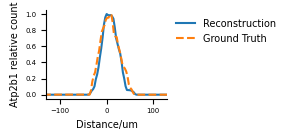

In [7]:
plt.figure(figsize=(3, 1.5))
sns.lineplot(x=CA1_values['distance_um'].values.flatten()
             , y=CA1_values['c58_8_recon'].values.flatten()/CA1_values['c58_8_recon'].values.max(), label='Reconstruction')
sns.lineplot(x=CA1_values['distance_um'].values.flatten() + 10
             , y=CA1_values['c58_8_truth'].values.flatten()/CA1_values['c58_8_truth'].values.max(), 
             label='Ground Truth', linestyle='--')

plt.xlabel('Distance/um', fontsize=7)
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
plt.ylabel('Atp2b1 relative count', fontsize=7)
# plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(-130,130)
plt.tick_params(axis='both', which='both',labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig2','Fig2h_3_CA_width_comparison.svg'),dpi=300)
plt.show()

## FigS3_e

In [15]:
fwhm_list = []

for col in CA1_values.columns[1:-1]:
    print(col)
    x = CA1_values['distance_um'].values.flatten()
    y = CA1_values[col].values.flatten()/CA1_values[col].values.max()
    peak_value = np.max(y)
    
    # Step 2: Find half maximum
    half_max = peak_value / 2
    
    # Step 3: Locate points on the distribution
    # np.abs(y - half_max) finds the absolute difference between y values and half max
    # np.argmin finds the index of the smallest value in this difference array, 
    # which will be closest to the half maximum
    left_idx = np.argmin(np.abs(y[:len(y)//2] - half_max))
    right_idx = np.argmin(np.abs(y[len(y)//2:] - half_max)) + len(y)//2
    
    # Step 4: Calculate FWHM
    fwhm= x[right_idx] - x[left_idx]
    fwhm_list.append(fwhm)
    
    print("FWHM:", fwhm)


c58_8_truth
FWHM: 49.51456310679612
c58_8_recon
FWHM: 43.689320388349515
c58_5_truth
FWHM: 52.42718446601942
c58_5_recon
FWHM: 49.51456310679612
c58_4_truth
FWHM: 37.86407766990291
c58_4_recon
FWHM: 32.03883495145631


In [24]:
fwhm_pd = pd.DataFrame({'fwhm':fwhm_list,'exp':[i[:5] for i in CA1_values.columns[1:-1]],'type':['truth','recon']*3})

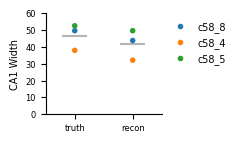

In [60]:
plt.figure(figsize=(2.5, 1.5))
ax=sns.stripplot(data=fwhm_pd, x="type", y="fwhm",hue='exp',s=4,hue_order=['c58_8','c58_4','c58_5'],jitter=False)
plt.plot(np.linspace(-0.2,0.2,2),[np.mean(fwhm_pd[fwhm_pd.type=='truth'].fwhm.values)]*2,c='#B4B4B4')
plt.plot(np.linspace(0.8,1.2,2),[np.mean(fwhm_pd[fwhm_pd.type=='recon'].fwhm.values)]*2,c='#B4B4B4')
plt.xlim(-0.5,1.5)
plt.xlabel('', fontsize=7)
plt.ylabel('CA1 Width', fontsize=7)
plt.tick_params(axis='both', which='both',labelsize=6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
plt.tight_layout()
plt.ylim(0,60)
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS2','FigS2r_CA1_width_comparison.svg'),dpi=300)
plt.show()

# Cell types

## FigS4_a

In [25]:
RCTD_weights = pd.read_csv(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/data/c58_8/c58_8','slide_seq',
                                          'RCTD_Plots_recon_min20/{}_weights_recon.csv'.format(sample)))

RCTD_weights.columns = ['barcode'] + RCTD_weights.columns[1:].tolist()
RCTD_weights.set_index('barcode', inplace=True)

weights_bead = adata_recon.obs
weights_bead = weights_bead.merge(RCTD_weights, left_index=True, right_index=True)

bead_loc = pd.DataFrame(adata_recon.obsm['spatial'], index=adata_recon.obs.index, columns=['xcoord','ycoord'])
bead_loc.ycoord = - bead_loc.ycoord

weights_bead = weights_bead.merge(bead_loc, left_index=True, right_index=True)

/tmp/ipykernel_3621088/594283544.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


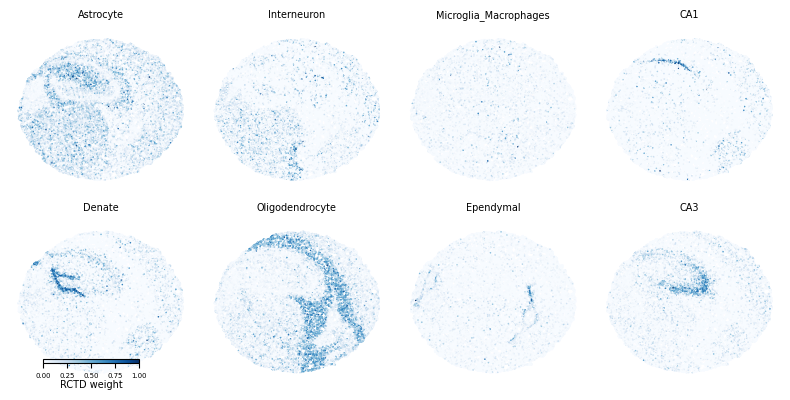

In [27]:
type8 = ['Astrocyte', 'Interneuron', 'Microglia_Macrophages', 'CA1', 'Denate', 'Oligodendrocyte', 'Ependymal', 'CA3']

fig, axs = plt.subplots(2, 4, figsize=(8, 4))

for i, ax in enumerate(axs.flat):
    sns.scatterplot(weights_bead, x="xcoord", y="ycoord", hue=type8[i], s=1, edgecolor=None, 
                    palette=sns.color_palette("Blues", as_cmap=True), ax=ax, legend=False)
    ax.set_title(type8[i], fontsize=7, pad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

cbar_ax = fig.add_axes([0.06, 0.08, 0.12, 0.01])  # x-position, y-position, width, height
# Create the color bar
norm = plt.Normalize(vmin=0, vmax=1)  # Assuming your gradient values are between 0 and 1
sm = plt.cm.ScalarMappable(cmap=sns.color_palette("Blues", as_cmap=True), norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=5)
cbar.set_label('RCTD weight', fontsize=7, labelpad=1)

# plt.savefig(os.path.join(out_dir,'FigS2i_RCTD_8_type_weights.png'),dpi=300)
plt.tight_layout()
plt.show()

## FigS4_b

In [35]:
RCTD_weights_truth = pd.read_csv(os.path.join(sample_folder,'slide_seq',
                                          'RCTD_Plots_truth_min20/{}_weights_truth.csv'.format(sample)))

RCTD_weights_truth.columns = ['barcode'] + RCTD_weights_truth.columns[1:].tolist()
RCTD_weights_truth.set_index('barcode', inplace=True)

weights_bead_truth = adata_truth.obs
weights_bead_truth = weights_bead_truth.merge(RCTD_weights_truth, left_index=True, right_index=True)

bead_loc_truth = pd.DataFrame(adata_truth.obsm['spatial'], index=adata_truth.obs.index, columns=['xcoord','ycoord'])
bead_loc_truth.ycoord = - bead_loc_truth.ycoord

weights_bead_truth = weights_bead_truth.merge(bead_loc_truth, left_index=True, right_index=True)

/tmp/ipykernel_3570024/4084284792.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


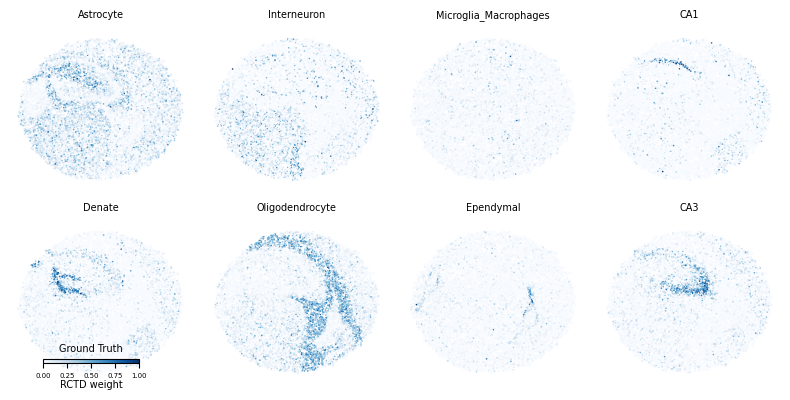

In [37]:
type8 = ['Astrocyte', 'Interneuron', 'Microglia_Macrophages', 'CA1', 'Denate', 'Oligodendrocyte', 'Ependymal', 'CA3']

fig, axs = plt.subplots(2, 4, figsize=(8, 4))

for i, ax in enumerate(axs.flat):
    sns.scatterplot(weights_bead_truth, x="xcoord", y="ycoord", hue=type8[i], s=1, edgecolor=None, 
                    palette=sns.color_palette("Blues", as_cmap=True), ax=ax, legend=False)
    ax.set_title(type8[i], fontsize=7, pad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

cbar_ax = fig.add_axes([0.06, 0.08, 0.12, 0.01])  # x-position, y-position, width, height
# Create the color bar
norm = plt.Normalize(vmin=0, vmax=1)  # Assuming your gradient values are between 0 and 1
sm = plt.cm.ScalarMappable(cmap=sns.color_palette("Blues", as_cmap=True), norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=5)
cbar.set_label('RCTD weight', fontsize=7, labelpad=1)

plt.title('Ground Truth', fontsize=7, pad=5)
# plt.savefig(os.path.join(out_dir,'FigS2m_RCTD_8_type_weights_truth.png'),dpi=300)
plt.tight_layout()
plt.show()

# Gene expression

## FigS5_a

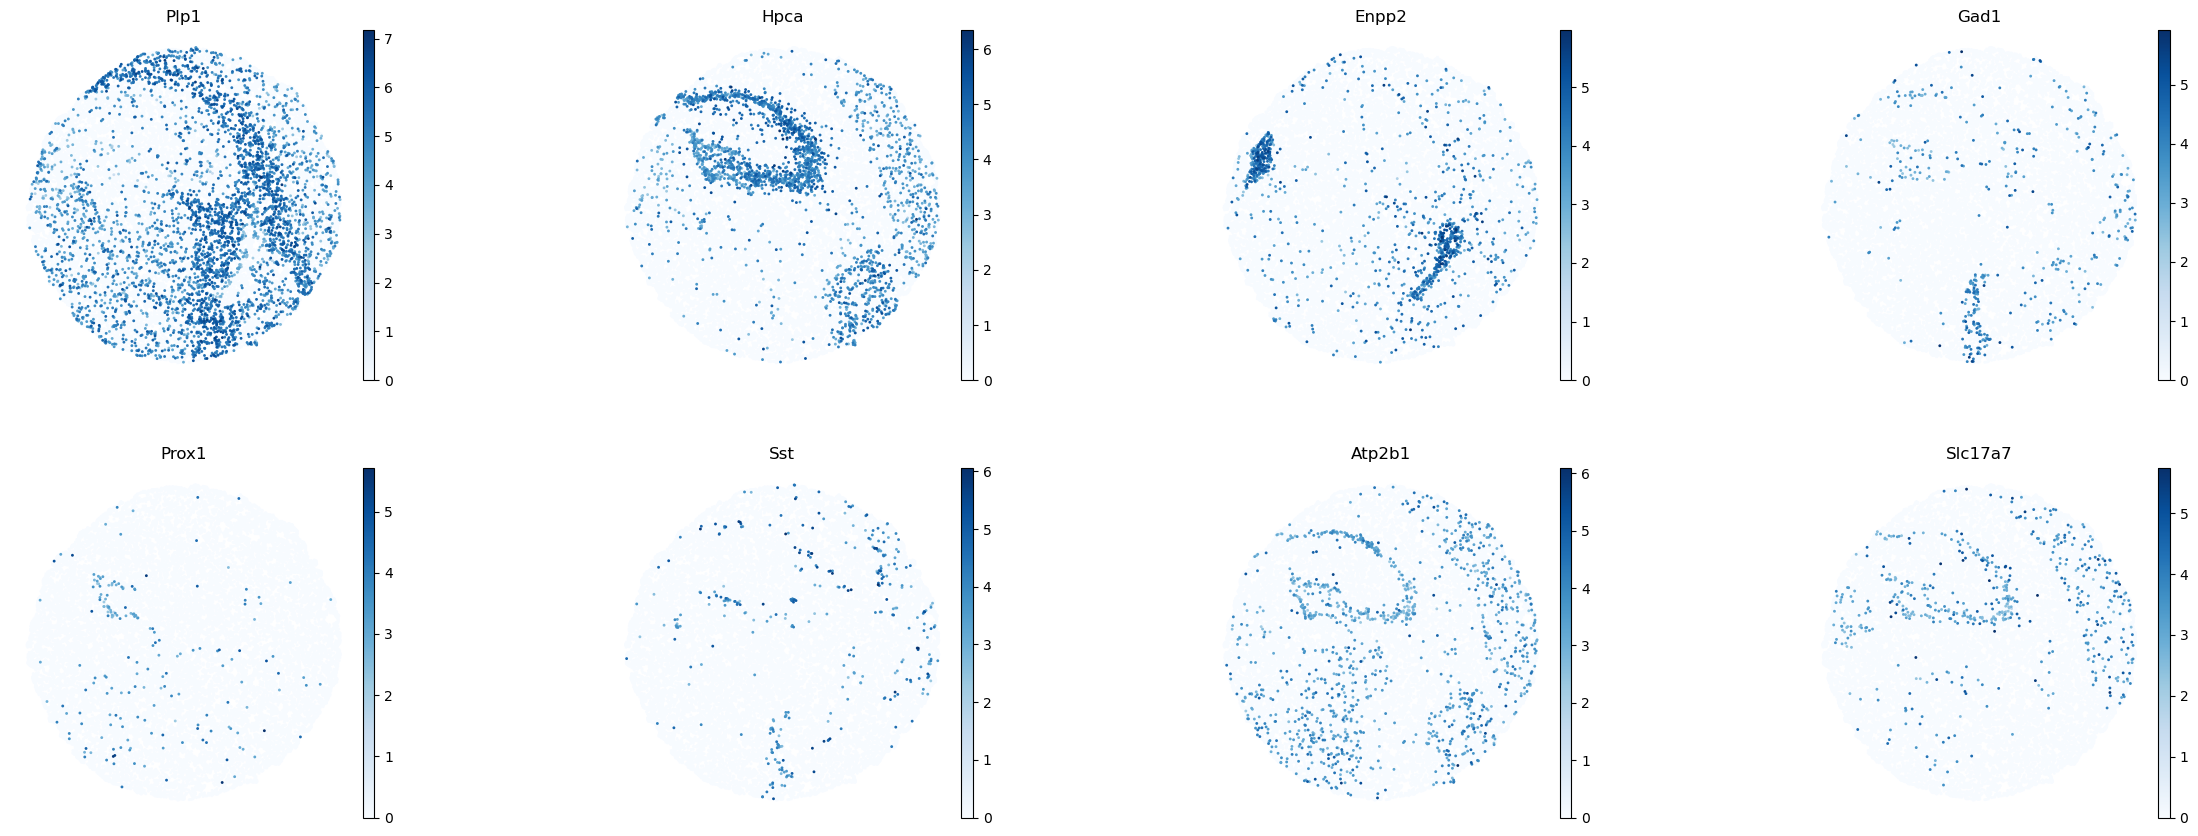

In [22]:
gene8 = ['Plp1', 'Hpca', 'Enpp2', 'Gad1', 'Prox1', 'Sst', 'Atp2b1', 'Slc17a7']

sc.pl.spatial(adata_recon, color=gene8, spot_size=20,
              cmap='Blues',size=1,frameon=False)#, save='FigS2k_8_gene.png')

# FigS5_b

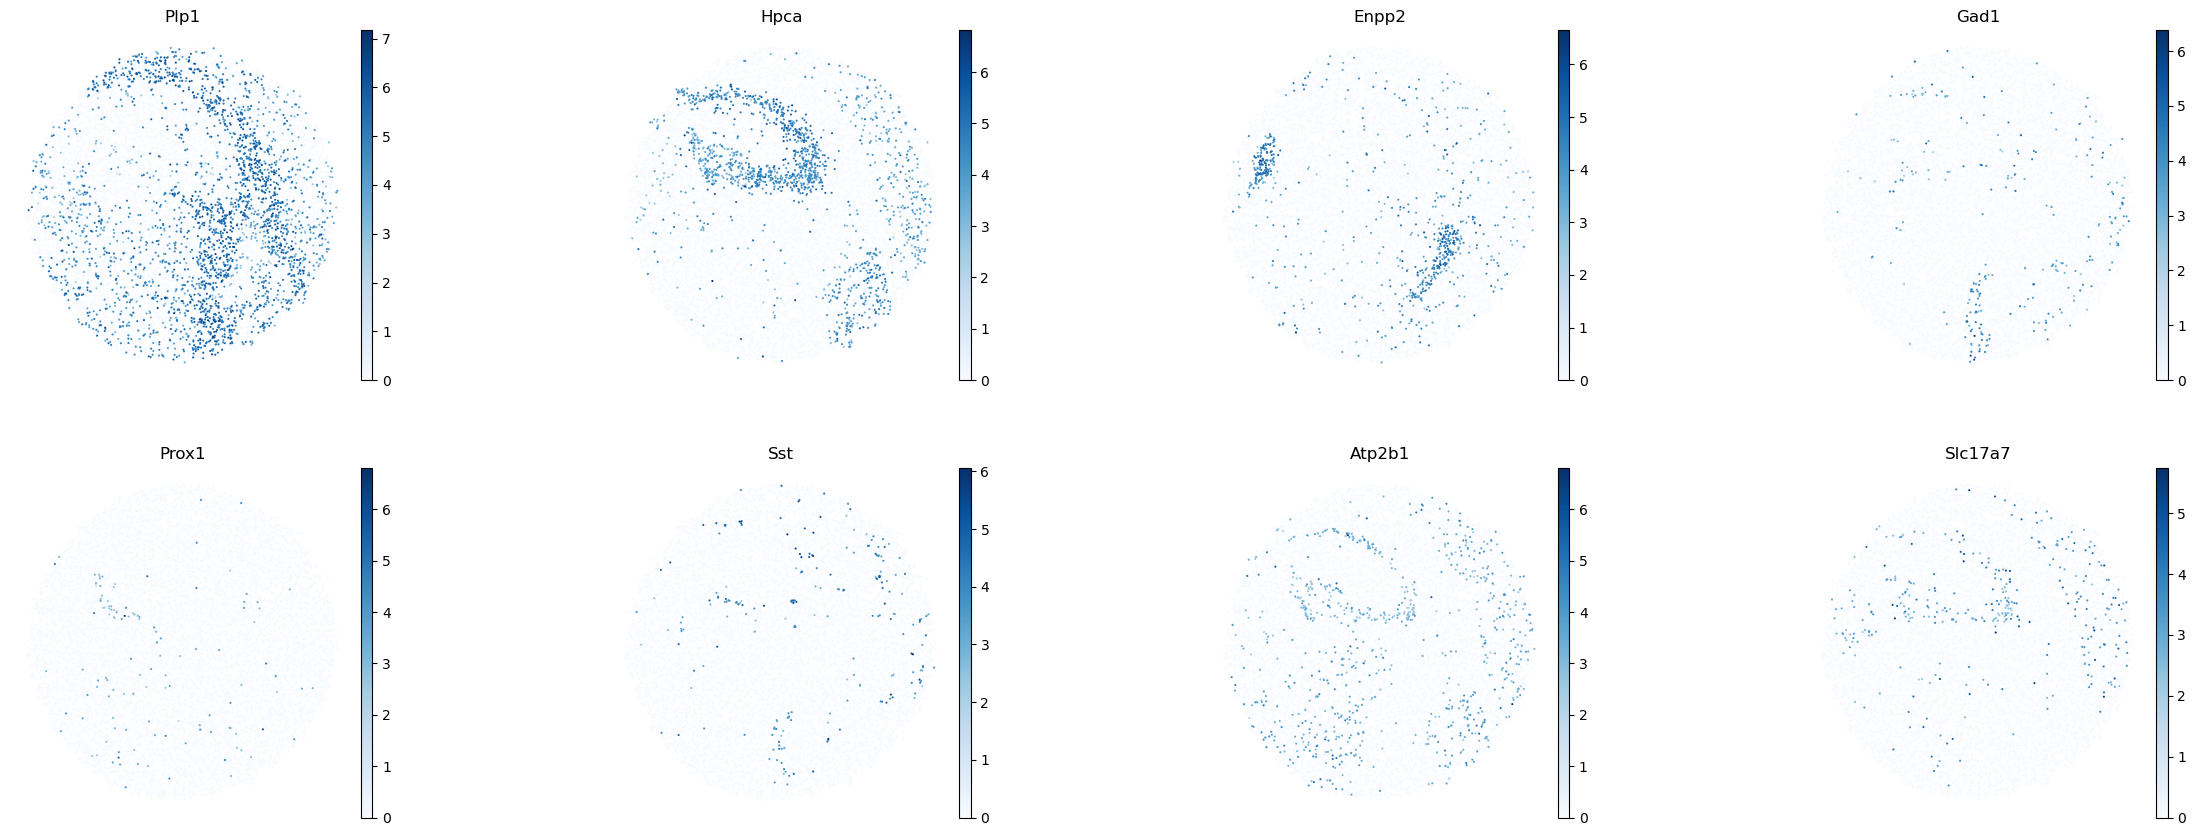

In [23]:
gene8 = ['Plp1', 'Hpca', 'Enpp2', 'Gad1', 'Prox1', 'Sst', 'Atp2b1', 'Slc17a7']

sc.pl.spatial(adata_truth, color=gene8, spot_size=20,
              cmap='Blues',size=1,frameon=False)#,save='FigS2n_8_gene_truth.png')

# Compare recon vs truth matched bead / UMI

In [10]:
compare_sum = pd.DataFrame({'sample':['data','data','replicate 1','replicate 1','replicate 2','replicate 2','data','data','replicate 1','replicate 1','replicate 2','replicate 2'],
                           'type':['truth','recon','truth','recon','truth','recon','truth','recon','truth','recon','truth','recon'],
                            'data_type':['matched_bead','matched_bead','matched_bead','matched_bead','matched_bead','matched_bead','matched_umi','matched_umi','matched_umi','matched_umi','matched_umi','matched_umi'],
                           'data':[1, len(adata_recon_c58_8.obs_names)/ len(adata_truth_c58_8.obs_names),
                                          1, len(adata_recon_c58_4.obs_names)/ len(adata_truth_c58_4.obs_names),
                                          1, len(adata_recon_c58_5.obs_names)/ len(adata_truth_c58_5.obs_names),
                                   1, np.sum(adata_recon_c58_8.obs['total_counts'])/np.sum(adata_truth_c58_8.obs['total_counts']),
                                         1, np.sum(adata_recon_c58_4.obs['total_counts'])/np.sum(adata_truth_c58_4.obs['total_counts']),
                                         1, np.sum(adata_recon_c58_5.obs['total_counts'])/np.sum(adata_truth_c58_5.obs['total_counts'])]})

In [11]:
bead_mean = np.mean([len(adata_recon_c58_8.obs_names)/ len(adata_truth_c58_8.obs_names),len(adata_recon_c58_4.obs_names)/ len(adata_truth_c58_4.obs_names),len(adata_recon_c58_5.obs_names)/ len(adata_truth_c58_5.obs_names)])

In [12]:
umi_mean = np.mean([np.sum(adata_recon_c58_8.obs['total_counts'])/np.sum(adata_truth_c58_8.obs['total_counts']),
                                         np.sum(adata_recon_c58_4.obs['total_counts'])/np.sum(adata_truth_c58_4.obs['total_counts']),
                                         np.sum(adata_recon_c58_5.obs['total_counts'])/np.sum(adata_truth_c58_5.obs['total_counts']),])

## FigS3_f

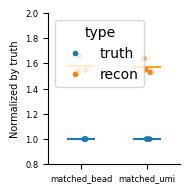

In [20]:
## Fig2p

plt.figure(figsize=(2, 2))
ax=sns.stripplot(data=compare_sum, x="data_type", y="data",hue='type',s=4)
plt.plot(np.linspace(-0.2,0.2,2),[1]*2,c='#1f77b4')
plt.plot(np.linspace(-0.2,0.2,2),[bead_mean]*2,c='orange')
plt.plot(np.linspace(0.8,1.2,2),[1]*2,c='#1f77b4')
plt.plot(np.linspace(0.8,1.2,2),[umi_mean]*2,c='orange')
plt.xlim(-0.5,1.5)
plt.xlabel('', fontsize=7)
plt.ylabel('Normalized by truth', fontsize=7)
plt.tick_params(axis='both', which='both',labelsize=6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0, 1))
plt.tight_layout()
plt.ylim(0.8,2)
plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig2','Fig2p_matched_counts_comparison.svg'),dpi=300)
plt.show()